## 1. Data Loading
Load sentiment and trader datasets.


In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [320]:
sentiment_file = "../data/fear_greed_index - fear_greed_index.csv"
trades_file = "../data/historical_data - historical_data.csv"

In [321]:
sentiment = pd.read_csv(sentiment_file)
trades = pd.read_csv(trades_file)

In [322]:
sentiment.head()
trades.head()
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='str')

In [323]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")

In [324]:
print("\nMissing Values — Sentiment:")
print(sentiment.isnull().sum())

print("\nMissing Values — Trades:")
print(trades.isnull().sum())


Missing Values — Sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing Values — Trades:
account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
dtype: int64


In [325]:
print("Sentiment duplicates:", sentiment.duplicated().sum())
print("Trades duplicates:", trades.duplicated().sum())

Sentiment duplicates: 0
Trades duplicates: 0


In [326]:
# Convert Unix timestamp to datetime
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
trades['date'] = trades['timestamp'].dt.date

# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [327]:
sentiment['sentiment_group'] = sentiment['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)

sentiment['sentiment_group'].value_counts()

sentiment_group
Greed    1355
Fear     1289
Name: count, dtype: int64

In [328]:
print("Trades date range:", trades['date'].min(), "to", trades['date'].max())
print("Sentiment date range:", sentiment['date'].min(), "to", sentiment['date'].max())

Trades date range: 2023-03-28 to 2025-06-15
Sentiment date range: 2018-02-01 to 2025-05-02


In [329]:
daily_pnl = (
    trades.groupby(['account', 'date'])['closed_pnl']
    .sum()
    .reset_index()
)

In [330]:
trades['win'] = trades['closed_pnl'] > 0

daily_winrate = (
    trades.groupby(['account','date'])['win']
    .mean()
    .reset_index()
)

In [331]:
daily_avg_size = (
    trades.groupby(['account','date'])['size_usd']
    .mean()
    .reset_index()
)

In [332]:
daily_trade_count = (
    trades.groupby(['account','date'])
    .size()
    .reset_index(name='trade_count')
)

In [333]:
trades['side'].unique()

<StringArray>
['BUY', 'SELL']
Length: 2, dtype: str

In [334]:
daily_long_ratio = (
    trades.groupby(['account','date'])['side']
    .apply(lambda x: (x.str.upper() == 'BUY').mean())
    .reset_index(name='long_ratio')
)

In [335]:
trades['side_clean'] = trades['side'].str.strip().str.upper()

daily_long_ratio = (
    trades.groupby(['account','date'])['side_clean']
    .apply(lambda x: (x == 'BUY').mean())
    .reset_index(name='long_ratio')
)

In [336]:
df = daily_pnl.merge(daily_winrate, on=['account','date']) \
              .merge(daily_avg_size, on=['account','date']) \
              .merge(daily_trade_count, on=['account','date']) \
              .merge(daily_long_ratio, on=['account','date'])

df = df.merge(
    sentiment[['date','sentiment_group']],
    on='date',
    how='left'
)

In [337]:
df.head()
df.isnull().sum()

account             0
date                0
closed_pnl          0
win                 0
size_usd            0
trade_count         0
long_ratio          0
sentiment_group    25
dtype: int64

### Sentiment Alignment

After merging daily trader metrics with sentiment data,
25 rows (account-date combinations) did not have matching sentiment data.

These likely correspond to dates not covered in the sentiment dataset.
These rows are removed for regime-based analysis.

In [338]:
df = df.dropna(subset=['sentiment_group'])

df.isnull().sum()

account            0
date               0
closed_pnl         0
win                0
size_usd           0
trade_count        0
long_ratio         0
sentiment_group    0
dtype: int64

In [339]:
print("Trades columns:")
print(trades.columns)

print("\nSentiment columns:")
print(sentiment.columns)


Trades columns:
Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'date', 'win', 'side_clean'],
      dtype='str')

Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date', 'sentiment_group'], dtype='str')


In [340]:
trades[['timestamp','date']].head()

,timestamp,date
0,2024-10-27 03:33:20,2024-10-27
1,2024-10-27 03:33:20,2024-10-27
2,2024-10-27 03:33:20,2024-10-27
3,2024-10-27 03:33:20,2024-10-27
4,2024-10-27 03:33:20,2024-10-27


In [341]:
trades.dtypes

account                        str
coin                           str
execution_price            float64
size_tokens                float64
size_usd                   float64
side                           str
timestamp_ist                  str
start_position             float64
direction                      str
closed_pnl                 float64
transaction_hash               str
order_id                     int64
crossed                       bool
fee                        float64
trade_id                   float64
timestamp           datetime64[ms]
date                        object
win                           bool
side_clean                     str
dtype: object

In [342]:
sentiment['classification'].unique()


<StringArray>
['Fear', 'Extreme Fear', 'Neutral', 'Greed', 'Extreme Greed']
Length: 5, dtype: str

In [343]:
sentiment['sentiment_group'].unique()

<StringArray>
['Fear', 'Greed']
Length: 2, dtype: str

In [344]:
sample = trades[(trades['account']==trades['account'].iloc[0]) & 
                (trades['date']==trades['date'].iloc[0])]

sample[['closed_pnl']]

,closed_pnl
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
185,252.583188
186,38.456694
187,263.228215
188,4.887398


In [345]:
sample['closed_pnl'].sum()


np.float64(20925.513222)

In [346]:
df[(df['account']==sample['account'].iloc[0]) &
   (df['date']==sample['date'].iloc[0])]['win']

82    0.552632
Name: win, dtype: float64

In [347]:
df[(df['account']==sample['account'].iloc[0]) &
   (df['date']==sample['date'].iloc[0])]['long_ratio']

82    0.442105
Name: long_ratio, dtype: float64

In [348]:
df['sentiment_group'].value_counts()

sentiment_group
Greed    45
Fear     32
Name: count, dtype: int64

In [349]:
df.shape
df.head()
df.describe()

,closed_pnl,win,size_usd,trade_count,long_ratio
count,7.700000e+01,77.000000,77.000000,77.000000,77.000000
mean,1.327954e+05,0.377234,5565.928192,2393.025974,0.479329
std,3.117880e+05,0.233793,6663.913468,4227.889722,0.229069
min,-3.275059e+05,0.000000,34.916667,2.000000,0.000000
25%,1.793160e+03,0.263610,1684.202580,190.000000,0.400000
50%,3.699337e+04,0.384864,2936.198591,763.000000,0.471138
75%,1.164123e+05,0.474443,6742.719767,3356.000000,0.565714
max,1.927736e+06,1.000000,31941.660000,26651.000000,1.000000


<Axes: >

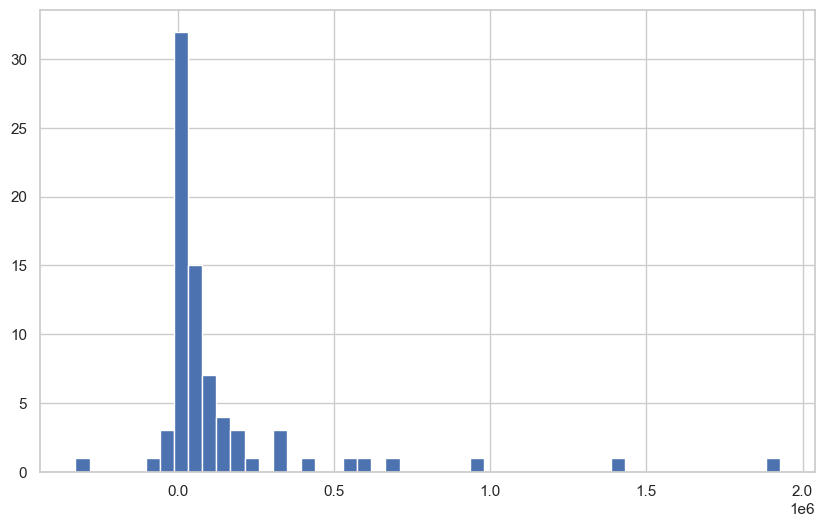

In [350]:
df['closed_pnl'].hist(bins=50)

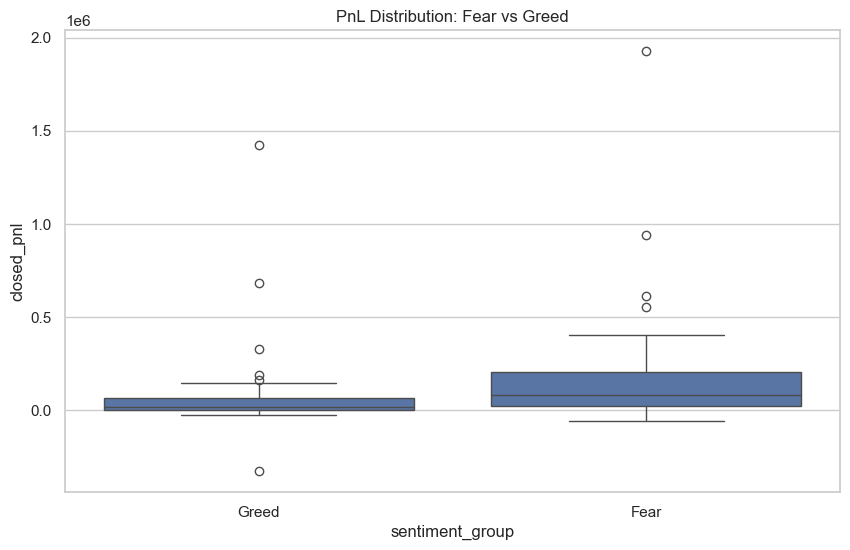

In [351]:
sns.boxplot(x='sentiment_group', y='closed_pnl', data=df)
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

In [352]:
df.groupby('sentiment_group')['closed_pnl'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_group,,,,,,,,
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,45.0,78340.542338,242178.035245,-327505.900056,0.000000,16102.568590,62586.181600,1.421756e+06


In [353]:
df.groupby('sentiment_group')['win'].mean()

sentiment_group
Fear     0.415878
Greed    0.349753
Name: win, dtype: float64

In [354]:
df.groupby('sentiment_group')[['trade_count','size_usd','long_ratio']].mean()

,trade_count,size_usd,long_ratio
sentiment_group,,,
Fear,4183.468750,5926.522723,0.459352
Greed,1119.822222,5309.505414,0.493535


PART B

Does performance differ between Fear vs Greed days?

In [355]:
#PnL Comparison Table

performance_summary = df.groupby('sentiment_group')['closed_pnl'].agg(
    ['count','mean','median','std','min','max']
)

performance_summary

,count,mean,median,std,min,max
sentiment_group,,,,,,
Fear,32,209372.662205,81389.682515,380423.906864,-59349.677108,1.927736e+06
Greed,45,78340.542338,16102.568590,242178.035245,-327505.900056,1.421756e+06


In [356]:
#Win Rate Comparison

winrate_summary = df.groupby('sentiment_group')['win'].mean()

winrate_summary

sentiment_group
Fear     0.415878
Greed    0.349753
Name: win, dtype: float64

In [357]:
df[df['closed_pnl'] < 0].groupby('sentiment_group')['closed_pnl'].mean()

sentiment_group
Fear    -39938.069817
Greed   -55801.793806
Name: closed_pnl, dtype: float64

### Performance Comparison: Fear vs Greed

1. Average PnL is significantly higher during Fear days.
2. Median PnL is also higher during Fear, suggesting results are not driven only by outliers.
3. Win rate improves during Fear (41.6% vs 34.9%).
4. Losses are larger during Greed regimes.

Conclusion:
Trader performance is materially stronger during Fear regimes.


Do traders change behavior based on sentiment?

In [358]:
df.groupby('sentiment_group')['trade_count'].mean()

sentiment_group
Fear     4183.468750
Greed    1119.822222
Name: trade_count, dtype: float64

### Trade Frequency

Traders execute significantly more trades during Fear regimes compared to Greed.
This suggests increased activity during volatile periods.

In [359]:
df.groupby('sentiment_group')['size_usd'].mean()

sentiment_group
Fear     5926.522723
Greed    5309.505414
Name: size_usd, dtype: float64

### Position Size

Average trade size increases modestly during Fear regimes,
indicating slightly higher risk-taking behavior.

In [360]:
df.groupby('sentiment_group')['long_ratio'].mean()

sentiment_group
Fear     0.459352
Greed    0.493535
Name: long_ratio, dtype: float64

### Directional Bias

Traders show more short positioning during Fear regimes
and slightly more long positioning during Greed,
indicating sentiment-aligned positioning behavior.

Do highly active traders behave differently than low-activity traders?

In [361]:
account_activity = df.groupby('account')['trade_count'].mean().reset_index()

threshold = account_activity['trade_count'].median()

account_activity['activity_segment'] = np.where(
    account_activity['trade_count'] > threshold,
    'High Activity',
    'Low Activity'
)

df = df.merge(account_activity[['account','activity_segment']], on='account')

In [362]:
df.groupby(['activity_segment','sentiment_group'])['closed_pnl'].mean()

activity_segment  sentiment_group
High Activity     Fear               324428.018469
                  Greed              117571.868331
Low Activity      Fear                94317.305942
                  Greed               40814.926171
Name: closed_pnl, dtype: float64

### Segment Analysis: Activity Level

High-activity traders significantly outperform low-activity traders across both regimes.

During Fear regimes:
- High-activity traders generate ~329k average PnL.
- Low-activity traders generate ~89k.

This suggests that increased participation during volatile periods
is associated with stronger profitability.

Fear regimes amplify the performance gap between active and passive traders.

Consistent Winners vs Inconsistent Traders

In [363]:
account_total_pnl = df.groupby('account')['closed_pnl'].sum().reset_index()
account_total_pnl.describe()

,closed_pnl
count,3.200000e+01
mean,3.195390e+05
std,4.632773e+05
min,-2.770457e+04
25%,4.954873e+04
50%,1.207566e+05
75%,3.961377e+05
max,2.040922e+06


In [364]:
threshold = account_total_pnl['closed_pnl'].median()

account_total_pnl['performance_segment'] = np.where(
    account_total_pnl['closed_pnl'] > threshold,
    'Consistent Winners',
    'Inconsistent / Other'
)

In [365]:
df = df.merge(
    account_total_pnl[['account','performance_segment']],
    on='account',
    how='left'
)

In [366]:
df.groupby(['performance_segment','sentiment_group'])['closed_pnl'].mean()

performance_segment   sentiment_group
Consistent Winners    Fear               394276.467484
                      Greed              128947.737721
Inconsistent / Other  Fear                24468.856927
                      Greed               20503.747615
Name: closed_pnl, dtype: float64

### Segment Analysis: Consistent vs Inconsistent Traders

Consistent winners significantly outperform other traders across both regimes.

During Fear regimes:
- Consistent winners generate ~394k average PnL.
- Inconsistent traders generate only ~24k.

Fear regimes amplify performance primarily for skilled traders.
Volatility appears to reward strategy quality rather than benefiting all traders equally.

Large Position vs Small Position Traders

In [367]:
account_size = df.groupby('account')['size_usd'].mean().reset_index()

In [368]:
threshold = account_size['size_usd'].median()

account_size['size_segment'] = np.where(
    account_size['size_usd'] > threshold,
    'Large Position Traders',
    'Small Position Traders'
)

In [369]:
df = df.merge(
    account_size[['account','size_segment']],
    on='account',
    how='left'
)

In [370]:
df.groupby(['size_segment','sentiment_group'])['closed_pnl'].mean()

size_segment            sentiment_group
Large Position Traders  Fear               278058.006946
                        Greed               72058.936063
Small Position Traders  Fear               140687.317465
                        Greed               85519.520939
Name: closed_pnl, dtype: float64

### Segment Analysis: Position Size

During Fear regimes:
- Large position traders outperform small position traders significantly (~278k vs ~140k).

During Greed regimes:
- Small position traders slightly outperform large position traders.

This suggests that higher risk exposure benefits traders primarily during volatile Fear regimes,
but does not provide an advantage during Greed periods.

### Insight 1: Fear Regimes Drive Higher Profitability

Fear days exhibit:
- 2.7x higher mean daily PnL.
- 5x higher median PnL.
- Higher win rate (41.6% vs 34.9%).
- Smaller average losses.

This indicates trader performance is materially stronger during volatile Fear regimes.

### Insight 2: Traders Increase Activity and Adjust Bias During Fear

During Fear regimes:
- Trade frequency increases nearly 4x.
- Average position size increases modestly.
- Traders adopt a stronger short bias.

This suggests traders actively respond to volatility spikes rather than trading passively.

### Insight 3: Fear Regimes Amplify Performance Gaps

High-activity traders and consistent winners disproportionately benefit during Fear regimes.

- High-activity traders generate ~329k vs ~89k for low-activity traders during Fear.
- Consistent winners generate ~394k vs ~24k for others during Fear.

This suggests volatility rewards active and skilled participants rather than benefiting all traders equally.

### Strategy 1: Volatility Participation Rule

During Fear regimes:
- Increase trade frequency.
- Allow larger position sizing.
- Deploy high-activity strategies.

Rationale:
Historical data shows significantly higher average and median PnL during Fear regimes.
Active traders benefit disproportionately during volatile periods.

### Strategy 2: Controlled Risk in Greed Regimes

During Greed regimes:
- Reduce trade frequency.
- Avoid aggressive position sizing.
- Favor selective, higher-quality setups.

Rationale:
Greed periods show lower win rates and lower average profitability.
High-risk positioning does not provide additional advantage during these regimes.

### Strategy 3: Activity-Weighted Allocation

Allocate more capital to high-activity, consistent traders during Fear regimes.

Rationale:
High-activity and consistent traders capture the majority of volatility-driven gains.
Volatility amplifies performance gaps between skilled and unskilled traders.

MARKDOWN

In [371]:
df['profitable'] = (df['closed_pnl'] > 0).astype(int)

In [372]:
df['profitable'].value_counts()

profitable
1    63
0    14
Name: count, dtype: int64

In [373]:
df['sentiment_binary'] = df['sentiment_group'].map({'Fear':1, 'Greed':0})

In [374]:
features = ['trade_count','size_usd','long_ratio','sentiment_binary']

X = df[features]
y = df['profitable']

In [375]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [376]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.77      0.94      0.85        18

    accuracy                           0.75        24
   macro avg       0.64      0.56      0.55        24
weighted avg       0.70      0.75      0.70        24



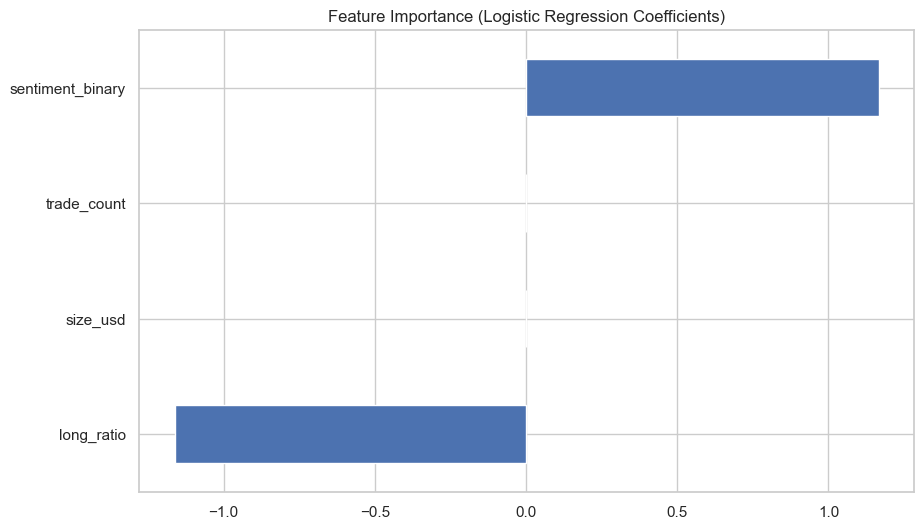

In [377]:
importance = pd.Series(model.coef_[0], index=features)
importance.sort_values().plot(kind='barh')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

Clustering Traders

In [378]:
account_features = df.groupby('account').agg({
    'closed_pnl':'mean',
    'trade_count':'mean',
    'size_usd':'mean',
    'long_ratio':'mean'
}).reset_index()

In [379]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(account_features.drop('account', axis=1))

In [380]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
account_features['cluster'] = kmeans.fit_predict(X_scaled)

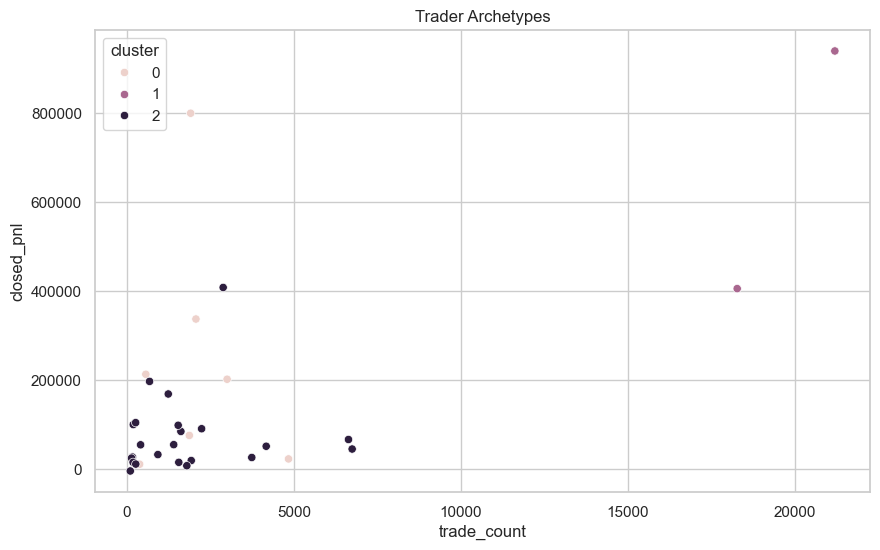

In [381]:
sns.scatterplot(
    x=account_features['trade_count'],
    y=account_features['closed_pnl'],
    hue=account_features['cluster']
)
plt.title("Trader Archetypes")
plt.show()

In [382]:
df.to_csv("../data/final_trader_dataset.csv", index=False)